### import

In [87]:
import os
import pickle
import openai
import config
import nltk
import utils
import mlflow
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from mlflow.data.pandas_dataset import PandasDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
#from gensim.summarization import summarize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN


prt = nltk.stem.PorterStemmer()
nltk.download('punkt')
#os.system('python -m pip install requirements.txt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nadav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### load the data

In [81]:
data_folder_path = './data'
word_count_num = 0

df = utils.load_data(data_folder_path, word_count_num)

### EDA

In [4]:
result = df.groupby('label')['text'].apply(lambda x: x.str.len().max()).reset_index()
result


,label,text
0,business,3209
1,entertainment,2611
2,food,2153
3,graphics,30051
4,historical,11194
5,medical,19476
6,politics,7324
7,space,15217
8,sport,2986
9,technologie,4232


In [5]:
df.groupby('label')['text'].apply(lambda x: x.str.len().describe()).unstack()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
business,100.0,1192.31,478.269834,533.0,903.75,1086.0,1326.50,3209.0
entertainment,100.0,1042.55,413.560138,592.0,780.00,880.5,1130.25,2611.0
food,100.0,842.83,296.741565,392.0,644.25,818.0,969.25,2153.0
graphics,100.0,1071.71,3004.980254,75.0,361.50,618.5,946.50,30051.0
historical,100.0,3133.00,2483.943724,299.0,1004.50,2635.5,4249.00,11194.0
medical,100.0,1662.04,3937.664828,70.0,370.50,539.5,863.00,19476.0
politics,100.0,1507.86,773.816281,491.0,1098.50,1517.0,1745.25,7324.0
space,100.0,1776.95,2972.382085,74.0,325.75,616.0,1308.00,15217.0
sport,100.0,1070.58,630.314146,421.0,615.50,891.5,1215.00,2986.0


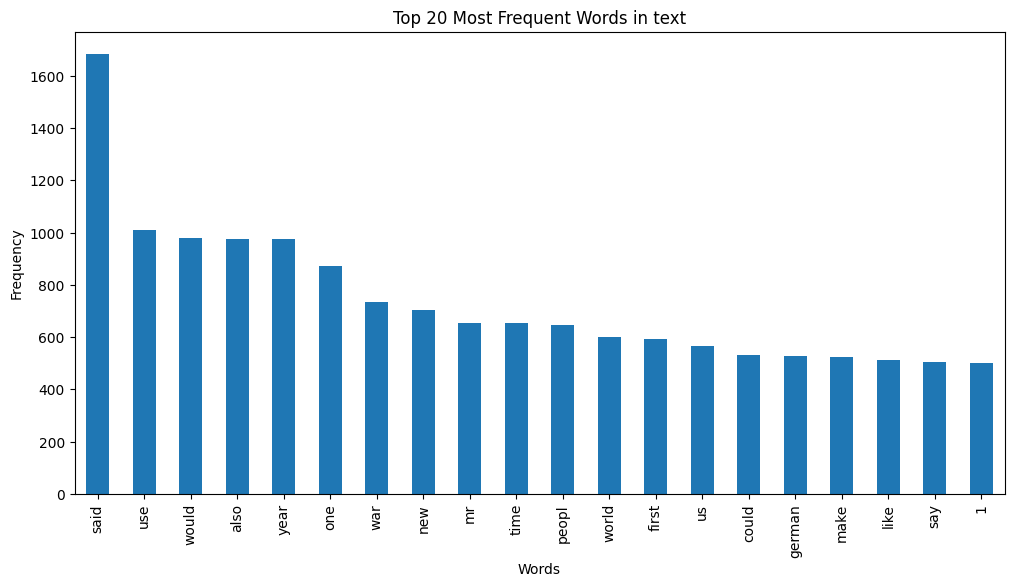

In [6]:
document_column = "text"

# create a series containing all the words in the document
all_words = pd.Series(' '.join(df[document_column]).lower().split())

# count the frequency of each word and sort by frequency
word_counts = all_words.value_counts().sort_values(ascending=False)

# specify the number of most frequent words to visualize
num_words_to_visualize = 20

# create a bar plot of the top N most frequent words
plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in {document_column}')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

### encode the text

In [7]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
encoded_texts = model.encode(df['text'])
pickle.dump(model , open('./pkl/model.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)

# encoded_summarize_texts = model.encode(df['summarize_text'])
# pickle.dump(model , open('../pkl/summarize_model.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)


### train and find accuracy

In [8]:
test_size_num = 0.2
max_iter_num = 1000

X_train, X_test, y_train, y_test = train_test_split(encoded_texts, df['label'], test_size=test_size_num, random_state=42)

clf = LogisticRegression(max_iter=max_iter_num)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#pickle.dump(clf , open('../pkl/clf.pkl' , 'wb'))

Accuracy: 0.915
Classification Report:
               precision    recall  f1-score   support

     business       1.00      0.90      0.95        20
entertainment       0.80      0.92      0.86        13
         food       1.00      0.93      0.96        27
     graphics       0.86      0.90      0.88        21
   historical       1.00      1.00      1.00        15
      medical       0.90      0.82      0.86        22
     politics       0.89      0.96      0.92        25
        space       0.81      1.00      0.90        13
        sport       1.00      1.00      1.00        23
  technologie       0.84      0.76      0.80        21

     accuracy                           0.92       200
    macro avg       0.91      0.92      0.91       200
 weighted avg       0.92      0.92      0.91       200



### mlflow

In [9]:
mlflow.set_experiment('Logistic Regression')

dataset: PandasDataset = mlflow.data.from_pandas(df)

with mlflow.start_run():
    mlflow.log_input(dataset)
    mlflow.log_param("data_folder_path", data_folder_path)
    mlflow.log_param("test_size_num", test_size_num)
    mlflow.log_param("max_iter_num", max_iter_num)
    mlflow.log_param("word_count_num", word_count_num)
    mlflow.log_artifact('./pkl/model.pkl')
    mlflow.log_artifact('./pkl/clf.pkl')
    mlflow.log_metric("accuracy", accuracy)


c:\python\final_project\venv\lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


### test new text with the model

In [10]:
new_text = ["the vast expanse beyond Earth's atmosphere, has long captivated human imagination and scientific curiosity. It's a realm of infinite wonder and mystery, where celestial bodies and phenomena defy our earthly understanding. One of the most awe-inspiring aspects of space is the sheer scale. It extends beyond our comprehension, with galaxies separated by immense distances. The Milky Way, our home galaxy, contains billions of stars, and there are billions of galaxies in the observable universe. Space is a place of extremes. In the vacuum of space, temperatures can range from scorching heat to frigid cold. On distant planets and moons, we find landscapes that challenge our perception of what is possible, from the towering volcanoes of Io to the icy geysers of Enceladus. "\
"Exploration of space has been a defining endeavor of human history. From the first satellite, Sputnik, to the monumental Apollo Moon missions, we have reached out to touch the stars. Today, robotic probes explore distant planets and spacecraft venture into the Kuiper Belt and beyond. "\
"Space is not only a realm of science but also a source of inspiration. It fuels our dreams of exploration and discovery, and it reminds us of our place in the grand tapestry of the cosmos. As we continue to gaze skyward, the mysteries of space continue to beckon, promising new insights and adventures that will shape the future of humanity"]
encoded_new_text = model.encode(new_text)

predicted_labels = clf.predict(encoded_new_text)

predicted_labels

array(['space'], dtype=object)

### create generated text with gpt3

In [26]:
generatedText = utils.generate_text_with_openai('sport')

encoded_new_text = model.encode(generatedText)

predicted_labels = clf.predict([encoded_new_text])
predicted_labels

[<OpenAIObject at 0x1d99b001900> JSON: {
  "text": "\n\nSynchronized Swimming\n\nSynchronized swimming is a sport in which a team of two or more swimmers perform a synchronized routine of aquatic movements. Synchronized swimming is a fun, challenging, and rewarding sport that provides fitness and performance benefits.\n\nSynchronized swimming is a very demanding sport that requires athletes to be in excellent physical condition. Aerobic fitness, strength, and flexibility are all important for synchronized swimmers. Synchronized swimming also requires a great deal of skill. Swimmers must be able to perform a wide range of movements in the water while maintaining timing and unison with their teammates.\n\nSynchronized swimming can provide many benefits to athletes. It is a great way to improve aerobic fitness and",
  "index": 0,
  "logprobs": null,
  "finish_reason": "length"
}]


Synchronized Swimming

Synchronized swimming is a sport in which a team of two or more swimmers perform a sy

array(['sport'], dtype=object)

In [ ]:
# openai.api_key = config.OPENAI_API_KEY if 'OPENAI_API_KEY' in dir(config) else ''
# print(f'openai.api_key : {openai.api_key}')

openai.api_key : 


### terminal commands

In [ ]:
#docker image build --tag text_labeling .
#docker images
#docker container run --publish 80:80 --name text_labeling-container text_labeling

#uvicorn main:app --reload

#pip freeze   

In [ ]:
# from gensim.summarization import summarize

# # Your long text
# long_text = df['text'][0]

# # Generate a summary
# summary = summarize(text=long_text)
# print(long_text)
# print(summary)

### clustering - kmeans

In [ ]:
mapping_dict = {'business': 0, 'entertainment': 1, 'food':2, 'graphics':3, 'historical': 4, 'medical': 5, 'politics': 6, 'space':7, 'sport': 8, 'technologie':9}

In [117]:
from sklearn.metrics import silhouette_score

documents = df['text']

df['label_as_number'] = df['label'].map(mapping_dict)
y = df['label_as_number']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

X_train, X_test,y_train,y_test =  train_test_split(X,y,test_size=0.20,random_state=70)

k_means = KMeans(n_clusters=10, n_init = 'auto')
k_means.fit(X_train)

y_pred = k_means.predict(X_test)
adjusted_rand_score(y_pred,y_test )


0.5358690775783919

In [76]:
pickle.dump(vectorizer , open('./pkl/vectorizer.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(k_means , open('./pkl/kmeans.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)

In [123]:
new_text_data = new_text

X_new = vectorizer.transform(new_text_data)

cluster_labels_new = k_means.predict(X_new)

print(list(mapping_dict.keys())[list(mapping_dict.values()).index(cluster_labels_new)])


space


In [124]:
from sklearn.metrics import silhouette_score

documents = df['text']

df['label_as_number'] = df['label'].map(mapping_dict)
y = df['label_as_number']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

k_means_x = KMeans(n_clusters=10, n_init = 'auto')
k_means_x.fit(X)


KMeans(n_clusters=10, n_init='auto')

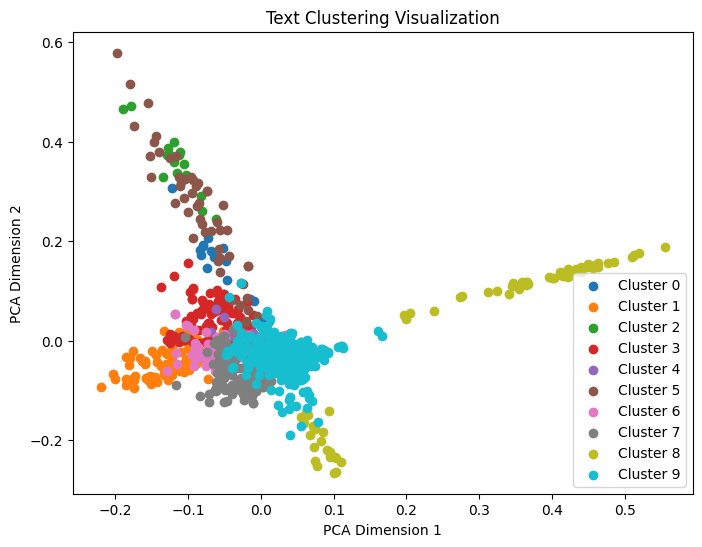

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

cluster_labels = k_means_x.labels_

# Reduce dimensionality for visualization (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot to visualize clusters
plt.figure(figsize=(8, 6))

for i in range(10):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('Text Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()

plt.savefig("./plot/clustering.png")
plt.show()


In [126]:
mlflow.set_experiment('KMeans Clustering')

dataset: PandasDataset = mlflow.data.from_pandas(df)

with mlflow.start_run():
    mlflow.log_input(dataset)
    mlflow.log_param("data_folder_path", data_folder_path)
    mlflow.log_artifact('./pkl/kmeans.pkl')
    mlflow.log_artifact('./pkl/vectorizer.pkl')
    #mlflow.log_metric("ari_score", ari_score)
    mlflow.log_artifact("./plot/clustering.png", artifact_path="plots")

c:\python\final_project\venv\lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\python\final_project\venv\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infer_

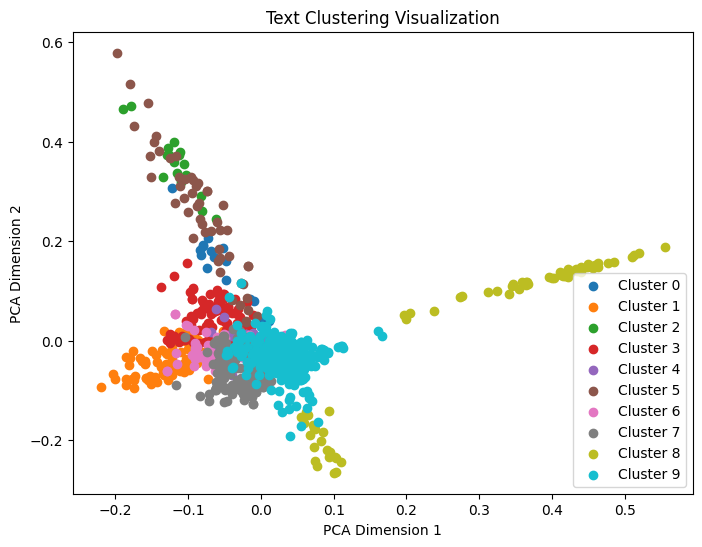

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot to visualize clusters
plt.figure(figsize=(8, 6))

for i in range(10):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('Text Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.show()


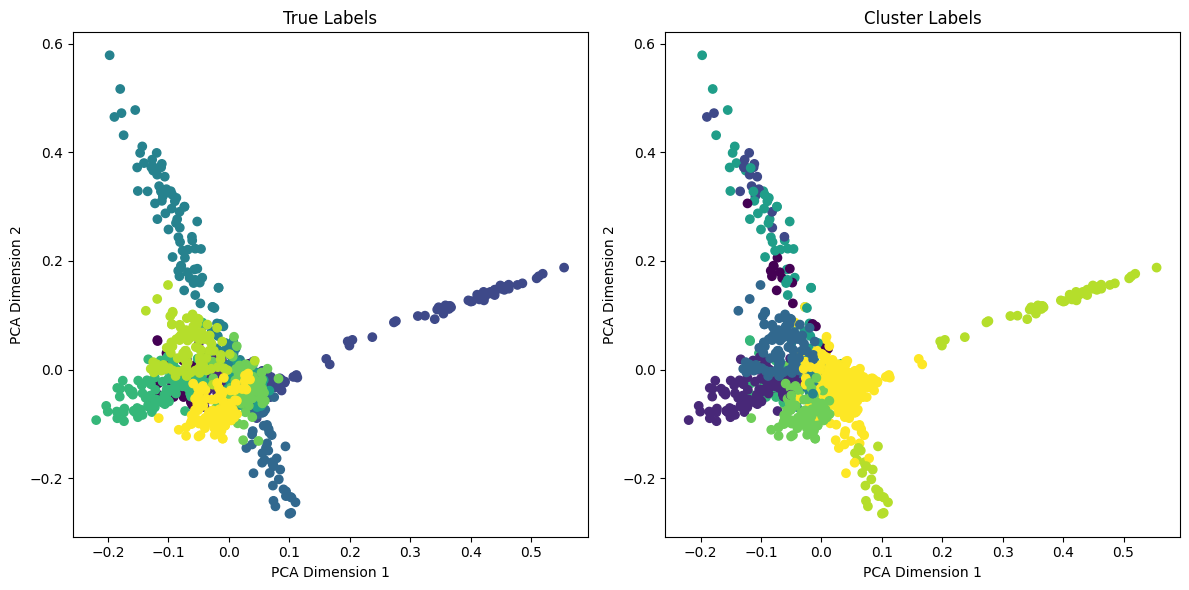

In [128]:
# Create scatter plot for true labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['label_as_number'], cmap='viridis')
plt.title('True Labels')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Cluster Labels')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.tight_layout()
plt.show()

